In [66]:
from glob import glob
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [6]:
logs = glob('model_logs/GNN1/*/version*/events.out*')
N_enc, N_conv, N_dim, errs = [], [], [], []

for log in logs:
	yaml_file = os.path.join(os.path.dirname(log), 'hparams.yaml')
	with open(yaml_file) as file:
		hparams = yaml.safe_load(file)
		
	event_acc = EventAccumulator(log)
	event_acc.Reload()
	err = np.mean(np.sort([x[2] for x in event_acc.Scalars('ptl/val_err')])[:5])
	
	N_enc.append(hparams['encoder_num_layers'])
	N_conv.append(hparams['num_layers'])
	N_dim.append(hparams['hidden_channels'])
	errs.append(err)

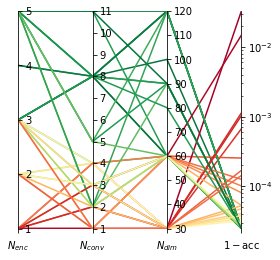

In [72]:
data = np.array([N_enc, N_conv, N_dim, errs]).T
labels = ['$N_{enc}$', '$N_{conv}$', '$N_{dim}$', '$1 - $acc']
cmap = cm.get_cmap('RdYlGn')
cnorm = colors.LogNorm(vmin=data[:, -1].min(), vmax=data[:, -1].max())

fig, host = plt.subplots(figsize=(4, 4))
ax = [host] + [host.twinx() for i in range(data.shape[1]-1)]

for i, a in enumerate(ax):
	a.set_ylim(data[:, i].min(), data[:, i].max())
	a.spines['top'].set_visible(False)
	a.spines['bottom'].set_visible(False)
	if ax != host:
		a.spines['left'].set_visible(False)
		a.yaxis.set_ticks_position('right')
		a.spines["right"].set_position(("axes", i / (data.shape[1]-1)))

host.set_xlim(0, data.shape[1]-1)
host.set_xticks(range(data.shape[1]))
host.set_xticklabels(labels)
host.tick_params(axis='x', which='major', pad=7)

Z = np.zeros_like(data)
Z[:, 0] = data[:, 0]
Z[:, 1:] = (data[:, 1:] - data[:, 1:].min(axis=0)) / (data[:, 1:].max(axis=0) - data[:, 1:].min(axis=0)) * (data[:, 0].max() - data[:, 0].min()) + data[:, 0].min()

for idx in range(data.shape[0]):
    host.plot(range(data.shape[1]), Z[idx, :], color=cmap(1-cnorm(data[idx, -1])), zorder=-1)
	
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[3].set_yscale('log')

fig.savefig('../report_gnn/figures/hparams.pdf')
plt.show(fig)

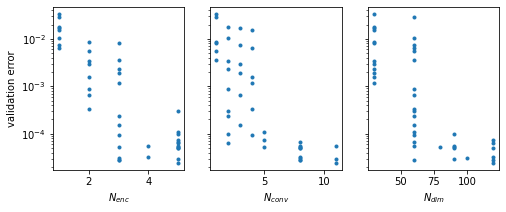

In [65]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=3, sharey=True)

ax[0].plot(N_enc, errs, 'o', markersize=3)
ax[1].plot(N_conv, errs, 'o', markersize=3)
ax[2].plot(N_dim, errs, 'o', markersize=3)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_ylabel('validation error')

ax[0].set_xlabel('$N_{enc}$')
ax[1].set_xlabel('$N_{conv}$')
ax[2].set_xlabel('$N_{dim}$')

plt.show(fig)